In [20]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures
using HDF5

### Initial Parameters

In [21]:
N = 151 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of the point at the center of the lattice.
dp = 0.1 #Discrete change in momentum

Delta = 0 #A constant factor that shifts the values of the momentum lattice. Delta=0 corresponds to periodic boundary conditions, while Delta=1/2 corresponds to "twisted" boundary conditions
mass = 0.01
p_i = [-(n_0*dp)+(s-Delta)*dp for s in 0:N-1] #List containing the momentum at each site in the lattice
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]; #Angular frequency of the field

### Hamiltonian

In [22]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9); #Create ITensor "SFT" sites

### Create the Vacuum State MPS

In [23]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [24]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
psi_gs = MPS(sites, MakeState(gs_Dict)); #Ground State

### Define the Field Operator and Wilson Line Operators

In [25]:
function phi_n(m::Real) #Field value in the lightlike direction, i.e. phi_x_{n_0+m}
    phi_lightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i) #n*m*dx = (1,1)*m*dx = (m*dx,m*dx)
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i)
    end
    return phi_lightlike
end

function phi_nbar(m::Real) #Field value in the anti-lightlike direction, i.e. phi_x_{n_0-m}
    phi_antilightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a", (i) #nbar*m*dx = (1,-1)*m*dx = (m*dx,-m*dx)
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a†", (i)
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [26]:
function Y_n(g::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*dx*phi_n(m)
    end
    return Y_n_op
end

function Y_nbar_dag(g::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*dx*phi_nbar(m)
    end
    return Y_nbar_dag_op
end

function YnbdYn(g::Real)
    return MPO(Y_nbar_dag(g)+Y_n(g), sites)
end

YnbdYn (generic function with 1 method)

### Prepare for Data Collection

In [27]:
t_range = range(0, stop=300, length=201) #Range of the timesteps
g_list = [0.05, 0.1] #List of coupling constant values
cutoff_list = [1.6e-26, 7e-13] #List of TDVP cutoff parameters for each value of g
if N > 14 #If N > 14, increase the threshold for ITensor's contraction warning
    ITensors.set_warn_order(N)
    ITensors.set_warn_order(N)
else #Else, reset the warning threshold to the default number of contractions, 14
    ITensors.set_warn_order(14)
    ITensors.set_warn_order(14)
end

151

In [28]:
SF_data = h5open("Soft_Function_data.h5", "r+") #Open the Soft Function data HDF5 file in read/write mode
if haskey(SF_data, "N=$N, m=$mass, dp=$dp") == false #Check if the "N=$N, m=$mass, dp=$dp" group doesn't exist
    create_group(SF_data, "N=$N, m=$mass, dp=$dp") #Create a group within the HDF5 file corresponding to the initial parameters
end
SF_data_group = SF_data["N=$N, m=$mass, dp=$dp"]

SF_MPS = h5open("Soft_Function_MPS.h5", "r+")
if haskey(SF_MPS, "N=$N, m=$mass, dp=$dp") == false
    create_group(SF_MPS, "N=$N, m=$mass, dp=$dp")
end
SF_MPS_group = SF_MPS["N=$N, m=$mass, dp=$dp"];

### Calculate S(t)

In [29]:
#Create the states |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω> for some value of g and t
function MakeStates(g, t, cutoff)
    Psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>
    
    psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Time evolve the ground state
    psi_t = tdvp(YnbdYn(g), 1, psi_t; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Apply the Wilson line operator
    Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Time evolve back

    return Psi_0, Psi_t
end

MakeStates (generic function with 1 method)

In [30]:
for (i, g) in enumerate(g_list)
    S_t_list = ComplexF64[] #Create temporary lists for storing S(t), the Psi_0 MPS, and the Psi_t MPS for a given value of g
    if haskey(SF_data_group, "g=$g") == false #Check if the "g=$g" subgroup doesn't exist
        create_group(SF_data_group, "g=$g") #Create a subgroup within the "N=$N, m=$mass, dp=$dp" group corresponding to the given value of g
        if haskey(SF_MPS_group, "g=$g") == false
            create_group(SF_MPS_group, "g=$g")
        end
        for t in t_range
            #Calculate S(t) by taking the inner product between |Psi_0> and |Psi_t>
            Psi_0, Psi_t = MakeStates(g, t, cutoff_list[i])

            #= if haskey(SF_MPS_group["g=$g"], "Psi_0, t=$t") == false
                SF_MPS_group["g=$g"]["Psi_0, t=$t"] = Psi_0 #Create a dataset containing the Psi_0 MPS at timestep t for a given value of g
            end
            if haskey(SF_MPS_group["g=$g"], "Psi_t, t=$t") == false
                SF_MPS_group["g=$g"]["Psi_t, t=$t"] = Psi_t #Create a dataset containing the Psi_t MPS at timestep t for a given value of g
            end =#
            
            S_t = inner(Psi_t, Psi_0)
            push!(S_t_list, S_t) #Store the S(t) value at timestep t
        end
        if haskey(SF_data_group["g=$g"], "S(t)") == false
            SF_data_group["g=$g"]["S(t)"] = S_t_list #Create a dataset containing the list of S(t) values at each timestep t for a given value of g
        end
    end
end

#Store the list of S(t) values into a dictionary 'keyed' by the corresponding value of g
S_t_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(t)"][i] for i in 1:length(t_range)] for g in g_list)

Dict{String, Vector{ComplexF64}} with 2 entries:
  "g=0.1"  => [1.0-5.16948e-16im, 0.968167-0.244265im, 0.875083-0.471525im, 0.7…
  "g=0.05" => [1.0-6.40221e-17im, 0.997601-0.0635982im, 0.990423-0.126785im, 0.…

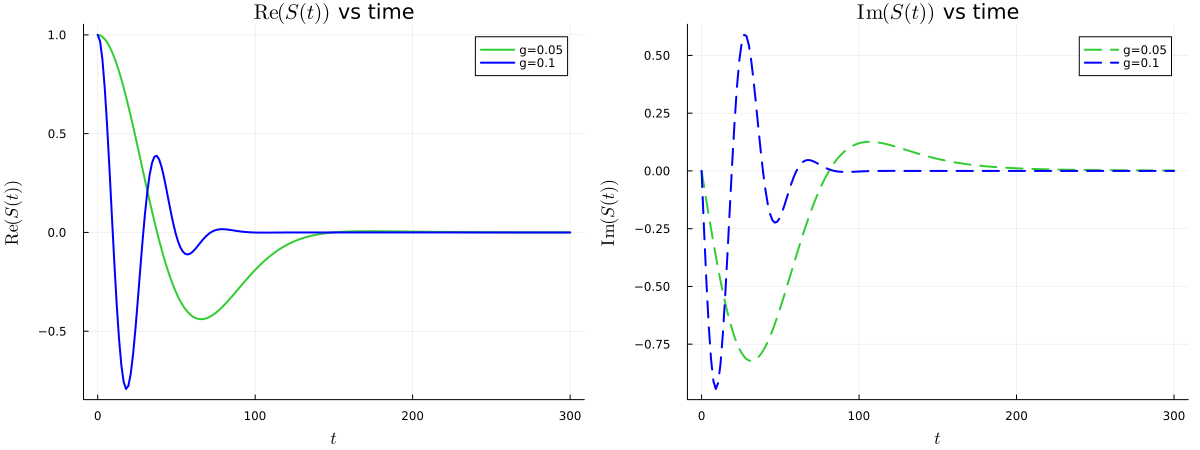

In [31]:
colors = ["lime green", "blue"]
Re_plt = plot()
for (i, g) in enumerate(g_list)
    Re_plt = plot!(
        t_range,
        real(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        color = colors[i]
    )
end

Im_plt = plot()
for (i, g) in enumerate(g_list)
    Im_plt = plot!(
        t_range,
        imag(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        ls = :dash,
        color = colors[i]
    )
end

plot(Re_plt, Im_plt, layout=(1,2), title=["\$\\mathrm{Re}(S(t))\$ vs time" "\$\\mathrm{Im}(S(t))\$ vs time"],
    guidefont=font(12),
    xlabel=["\$t\$" "\$t\$"],
    ylabel=["\$\\mathrm{Re}(S(t))\$" "\$\\mathrm{Im}(S(t))\$"],
    size=(1200, 450), 
    bottom_margin=18px,
    left_margin=22px)
#savefig("S(t) Plots/S(t), N=$N, m=23e-1, dp=417e-2")

### Calculate S(E)

In [32]:
function S(E::Real, S_t)
    dt = (2/dx)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [33]:
E_range = 0:0.01:1
for (i, g) in enumerate(g_list)
    S_E_list = ComplexF64[] #Create a temporary list for containing S(E) values for a given value of g
    S_E_list = [S(E, S_t_list_g["g=$g"]) for E in E_range] #Store S(E) for each value of E
    if haskey(SF_data_group["g=$g"], "S(E)") == false
        SF_data_group["g=$g"]["S(E)"] = S_E_list #Create a dataset containing the list of S(E) values at each energy E for a given value of g
    end
end

#Store the list of S(E) values into a dictionary 'keyed' by the corresponding value of g
S_E_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(E)"][i] for i in 1:length(E_range)] for g in g_list)

Dict{String, Vector{ComplexF64}} with 2 entries:
  "g=0.1"  => [1.28909e-12-0.0424231im, 1.04562e-9-0.0455494im, 1.15464e-7-0.04…
  "g=0.05" => [0.00196725-0.204143im, 0.0809287-0.304652im, 0.267868-0.321365im…

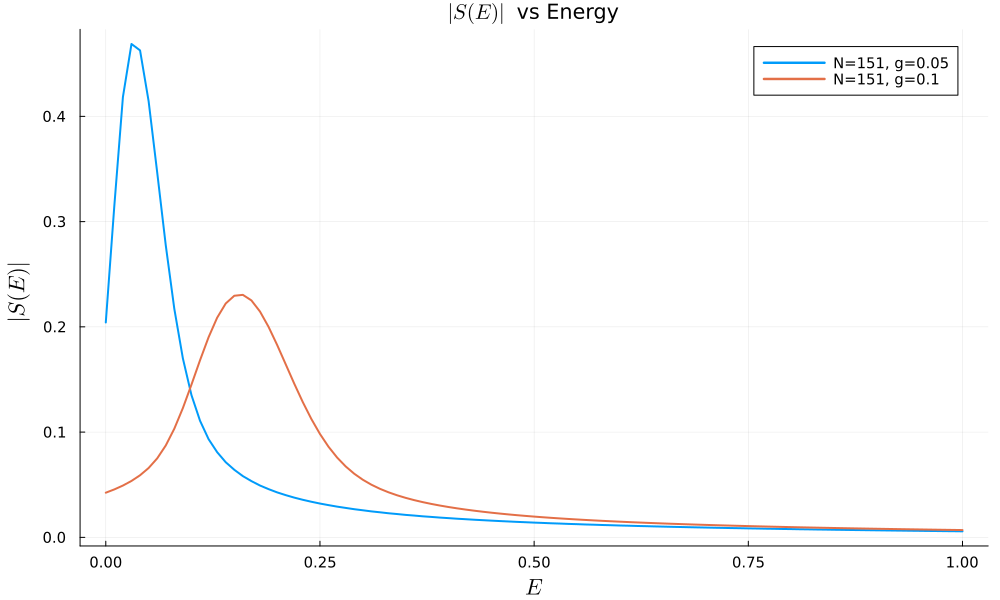

In [34]:
gr()
plot()
for g in g_list
    plot!(
        E_range,
        [abs(S_E_list_g["g=$g"][k]) for k in 1:length(E_range)];
        label = "N=$N, g=$g",
        lw =2
    )
end

xlabel!("\$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$", guidefont=font(15))
plot!(tickfontsize=10)
plot!(legendfontsize=10)
plot!(size = (1000, 600))
plot!(left_margin = 18px)
plot!(bottom_margin = 8px)
title!("\$|S(E)|\$ vs Energy")

#savefig("S(E) Plots/abs(S(E)), N=$N, g=[1e-1, 5e-2]")

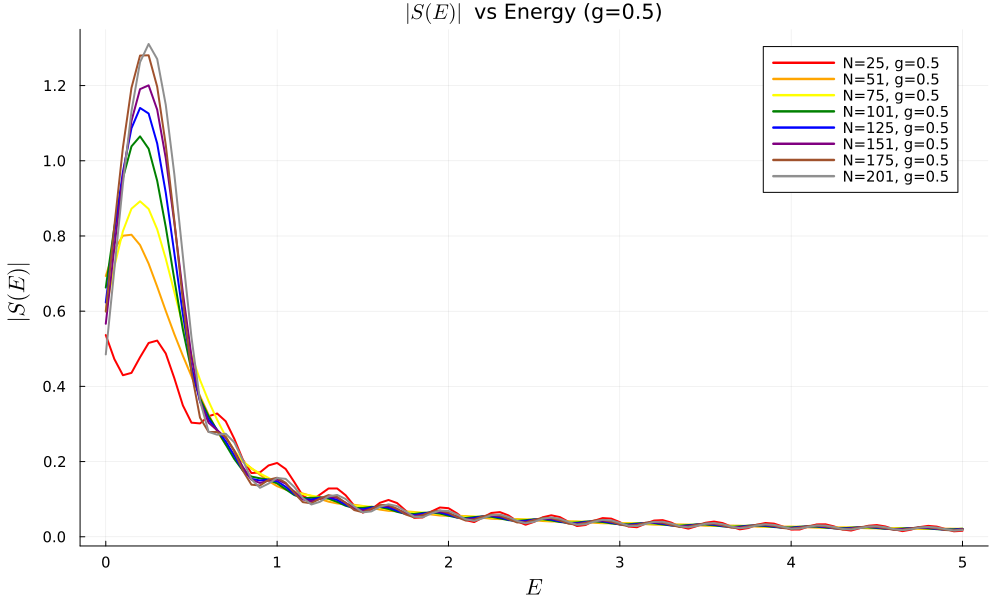

In [35]:
gr()
plot()
N_list = [25, 51, 75, 101, 125, 151, 175, 201]
group_name = ["N=$(N_list[i]), m=2.3, dp=$(12.5/((N_list[i])*dx))" for i in 1:length(N_list)]
colors = ["red", "orange", "yellow", "green", "blue", "purple", "sienna", "gray56"]
for (n, N) in enumerate(N_list)
    plot!(
        0:0.05:5,
        [abs(SF_data[group_name[n]]["g=0.5"]["S(E)"][k]) for k in 1:length(E_range)][1:101];
        label = "N=$N, g=0.5",
        lw = 2,
        ls = :solid,
        color = colors[n]
    )
end

xlabel!("\$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$", guidefont=font(15))
plot!(tickfontsize=10)
plot!(legendfontsize=10)
plot!(size = (1000, 600))
plot!(left_margin = 18px)
plot!(bottom_margin = 8px)
title!("\$|S(E)|\$ vs Energy (g=0.5)")

#savefig("S(E) Plots/abs(S(E)), N=25 to N=201, g=5e-1")

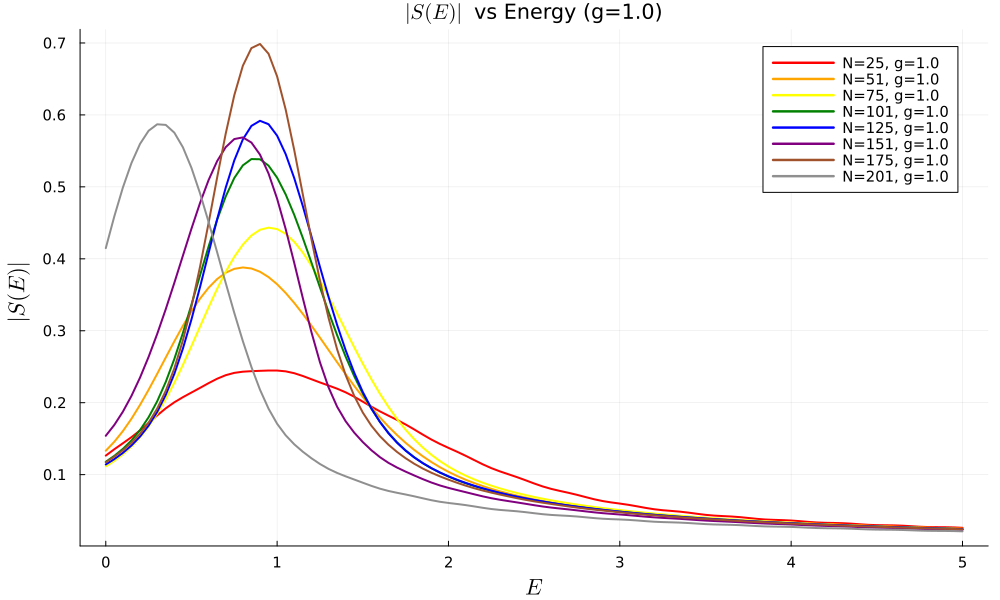

In [36]:
gr()
plot()
N_list = [25, 51, 75, 101, 125, 151, 175, 201]
group_name = ["N=$(N_list[i]), m=2.3, dp=$(12.5/((N_list[i])*dx))" for i in 1:length(N_list)]
colors = ["red", "orange", "yellow", "green", "blue", "purple", "sienna", "gray56"]
for (n, N) in enumerate(N_list)
    plot!(
        0:0.05:5,
        [abs(SF_data[group_name[n]]["g=1.0"]["S(E)"][k]) for k in 1:length(E_range)][1:101];
        label = "N=$N, g=1.0",
        lw = 2,
        ls = :solid,
        color = colors[n]
    )
end

close(SF_data)
close(SF_MPS)
xlabel!("\$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$", guidefont=font(15))
plot!(tickfontsize=10)
plot!(legendfontsize=10)
plot!(size = (1000, 600))
plot!(left_margin = 18px)
plot!(bottom_margin = 8px)
title!("\$|S(E)|\$ vs Energy (g=1.0)")

#savefig("S(E) Plots/abs(S(E)), N=25 to N=201, g=1")